In [1]:
import os.path
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import experimental
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

2023-12-24 23:26:50.504216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 23:26:50.504260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 23:26:50.583939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 23:26:50.743328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 23:26:51.906244: W tensorflow/compiler/tf2

In [2]:
def get_df_data(dir_path):
    # Все пути изображений
    img_path = list(dir_path.glob(r"*/*.jpg"))
    # Все названия классов
    classes = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], img_path))
    img_pathes = pd.Series(img_path, name="image").astype(str)
    classes = pd.Series(classes, name="class")
    return pd.concat([img_pathes, classes], axis=1)


# Получение данных пути фото и класса
df = get_df_data(Path("data"))
df

,image,class
0,data/cloudy/cloudy1.jpg,cloudy
1,data/cloudy/cloudy10.jpg,cloudy
2,data/cloudy/cloudy100.jpg,cloudy
3,data/cloudy/cloudy101.jpg,cloudy
4,data/cloudy/cloudy102.jpg,cloudy
...,...,...
1112,data/shine/shine95.jpg,shine
1113,data/shine/shine96.jpg,shine
1114,data/shine/shine97.jpg,shine
1115,data/shine/shine98.jpg,shine


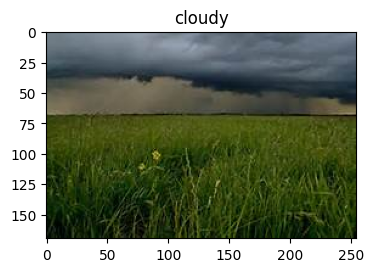

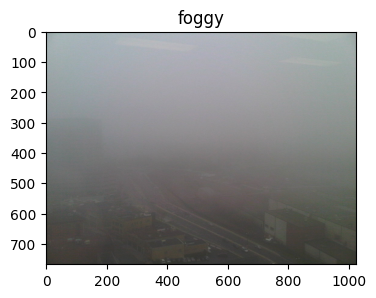

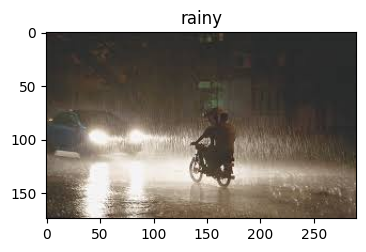

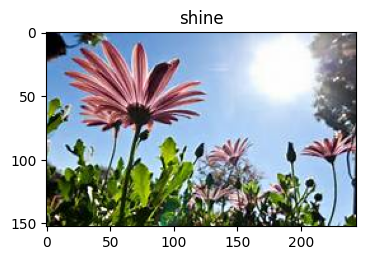

In [3]:
from PIL import Image


# Получение уникальных классов
classes = df['class'].unique()

# Вывод изображения для каждого класса
for class_name in classes:
    class_data = df[df['class'] == class_name] 
    image_path = class_data['image'].iloc[99]
    img = plt.imread(image_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(class_name)
    plt.show()

In [4]:
# Количество каждого класса в датасете
df["class"].value_counts()

class
cloudy    300
foggy     284
rainy     283
shine     250
Name: count, dtype: int64

In [5]:
# Разделение данных на обучающую и тестовую выборки для каждого класса
# train 70% val 15% test 15%
def train_val_test_split_by_classes(data, test_size=0.3):
    classes = data['class'].unique()
    
    train = pd.DataFrame()
    val = pd.DataFrame()
    test = pd.DataFrame()

    for class_name in classes:
        class_data = data[data['class'] == class_name]
        train_data, test_val_data = train_test_split(
            class_data, 
            test_size=test_size,
            random_state=123
            )
        val_data, test_data = train_test_split(
            test_val_data, 
            test_size=0.5, 
            random_state=123
            )
        
        train = pd.concat([train, train_data])
        val = pd.concat([val, val_data])
        test = pd.concat([test, test_data])
    
    return (train.reset_index(drop=True), 
            val.reset_index(drop=True),
            test.reset_index(drop=True), 
            )


train, val, test = train_val_test_split_by_classes(df, test_size=0.3)

In [6]:
# Нормализация
data_gen = ImageDataGenerator(rescale=1./255)

# Пакетная загрузка данных из Dataframe в генератор
train_gen = data_gen.flow_from_dataframe(dataframe=train,
                                               x_col="image",
                                               y_col="class",
                                               color_mode="rgb",
                                               class_mode="categorical")

val_gen = data_gen.flow_from_dataframe(dataframe=val,
                                               x_col="image",
                                               y_col="class",
                                               color_mode="rgb",
                                               class_mode="categorical")

test_gen = data_gen.flow_from_dataframe(dataframe=test,
                                               x_col="image",
                                               y_col="class",
                                               color_mode="rgb",
                                               class_mode="categorical")

num_train_samples = train_gen.n
print(f"Число образцов в обучающей выборке: {num_train_samples}")
num_val_samples = val_gen.n
print(f"Число образцов в валидационной выборке: {num_val_samples}")
num_test_samples = test_gen.n
print(f"Число образцов в тестовой выборке: {num_test_samples}")

Found 781 validated image filenames belonging to 4 classes.
Found 167 validated image filenames belonging to 4 classes.
Found 169 validated image filenames belonging to 4 classes.
Число образцов в обучающей выборке: 781
Число образцов в валидационной выборке: 167
Число образцов в тестовой выборке: 169


In [15]:
from keras.layers.experimental import preprocessing


batch_size = 1
epochs = 28


# Создание последовательной модели
model = Sequential([
    # Первый сверточный слой с 32 фильтрами размером 3x3.
    # Параметр padding='same' означает, что размерность выходных данных будет такой же, как и входных.
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=train_gen[0][0].shape[1:]),

    # Второй сверточный слой с 32 фильтрами размером 3x3. 
    Conv2D(32, (3, 3), activation='relu', padding='same'),

    # Слой максимального пулинга для уменьшения размерности пространственных данных.
    MaxPooling2D((2, 2)),

    # Слой Dropout для предотвращения переобучения, отключает 10% нейронов.
    Dropout(0.1),


    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.20),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Слой Flatten преобразует многомерный тензор в одномерный, что необходимо для полносвязных слоев.
    Flatten(),

    # Полносвязный слой с 512 нейронами.
    Dense(512, activation='relu'),

    # Слой Dropout отключает 50% нейронов.
    Dropout(0.5),

    # Выходной слой с 4 нейронами (по количеству классов). 
    # Функция активации softmax используется в задачах многоклассовой классификации.
    Dense(4, activation='softmax')
])


model.compile(optimizer="adam",
              loss="categorical_crossentropy",  # Используется categorical_crossentropy, так как у нас есть несколько классов
              metrics=["accuracy"])

model.fit(train_gen,
          validation_data=val_gen,
          epochs=epochs,
          batch_size=batch_size)

results = model.evaluate(test_gen)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Epoch 1/28


2023-12-24 23:55:59.185819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 5s 154ms/step - loss: 1.5373 - accuracy: 0.2894 - val_loss: 1.3368 - val_accuracy: 0.3892
Epoch 2/28
25/25 [==============================] - 4s 144ms/step - loss: 1.2451 - accuracy: 0.4161 - val_loss: 1.1681 - val_accuracy: 0.4731
Epoch 3/28
25/25 [==============================] - 4s 148ms/step - loss: 1.0893 - accuracy: 0.5186 - val_loss: 0.9790 - val_accuracy: 0.5329
Epoch 4/28
25/25 [==============================] - 4s 147ms/step - loss: 1.0855 - accuracy: 0.5621 - val_loss: 1.1076 - val_accuracy: 0.4671
Epoch 5/28
25/25 [==============================] - 4s 146ms/step - loss: 1.0903 - accuracy: 0.5365 - val_loss: 0.9432 - val_accuracy: 0.5928
Epoch 6/28
25/25 [==============================] - 4s 142ms/step - loss: 0.9455 - accuracy: 0.5992 - val_loss: 0.9038 - val_accuracy: 0.6287
Epoch 7/28
25/25 [==============================] - 4s 142ms/step - loss: 0.9120 - accuracy: 0.6108 - val_loss: 0.9678 - val_accuracy: 0.5749
Epoch 8/28
25/25 

1/1 [==============================] - 0s 56ms/step
cloudy


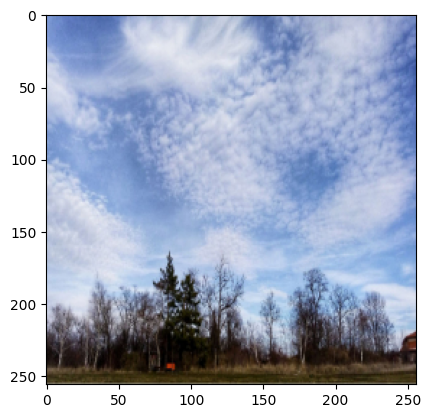

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np


# Функция предсказания
def predict(model, img):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Нормализация
    plt.imshow(img_array[0])
    prediction = model.predict(img_array)
    # Выводим класс самой большой вероятности
    classes = list(train_gen.class_indices.keys())
    print(classes[list(prediction[0]).index(max(prediction[0]))])
    
    
image_path = f"data/test/test1.jpg"
img = image.load_img(image_path, target_size=(256, 256))
predict(model, img)

1/1 [==============================] - 0s 12ms/step
shine


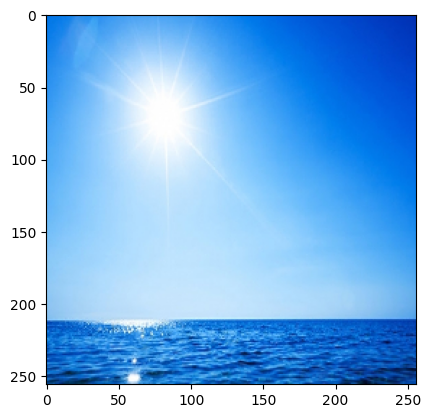

In [ ]:
image_path = f"data/test/test2.jpg"

img = image.load_img(image_path, target_size=(256, 256))
predict(model, img)

1/1 [==============================] - 0s 12ms/step
rainy


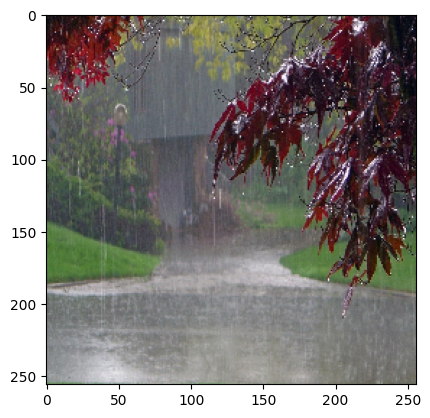

In [ ]:
image_path = f"data/test/test3.jpg"

img = image.load_img(image_path, target_size=(256, 256))
predict(model, img)

1/1 [==============================] - 0s 12ms/step
foggy


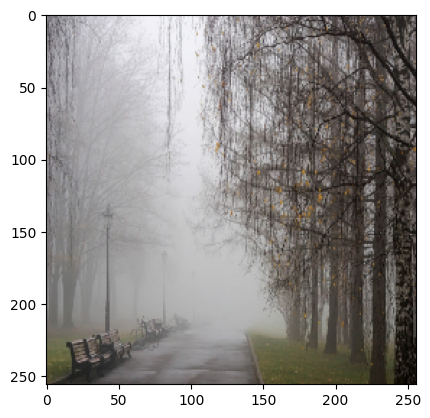

In [ ]:
image_path = f"data/test/test4.jpg"

img = image.load_img(image_path, target_size=(256, 256))
predict(model, img)